# Binary Sentiment Analysis

## Import Packages

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Tuple
import warnings
warnings.filterwarnings("ignore")

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
tokenizer = nltk.tokenize.punkt.PunktSentenceTokenizer()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import hamming_loss, accuracy_score, classification_report, roc_auc_score, confusion_matrix #Performance related
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Masking
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Conv1D
from keras.layers import MaxPooling1D

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Mounting on the drive to read data file
from google.colab import drive
%cd /content/drive/MyDrive/NLP_Project
drive.mount('/content/drive')

/content/drive/MyDrive/NLP_Project
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis

### Reading Data

In [6]:
# Using pd.read_csv() for reading the data
kindle_df_raw = pd.read_csv('kindle.csv',parse_dates=['reviewTime'])

NOTE: The size of this dataset file is 275.2 MB. Therefore the above code where pd.read_csv( ) has been used to read the data works fine. However, for larger datasets of sizes varying from 500 MB to 5 TB or more, this method of reading data is not efficient. Hence, for such cases, the recoomendation is to use open( ) function for reading data with readlines( ) method.

### Exploring Data

In [7]:
# Shape of the dataset
kindle_df_raw.shape

(410695, 11)

In [8]:
# Filtering for June onwards
kindle_df = kindle_df_raw[kindle_df_raw.reviewTime >= '2014-06-01']

In [9]:
# Shape of the dataset after filtering
kindle_df.shape

(115093, 11)

In [10]:
# Dropping the unnecessary columns
kindle_df = kindle_df.iloc[:,[2,4,5,6,-2]]
kindle_df = kindle_df.reset_index(drop='True')
kindle_df.columns = ['product_id','rating','review','review_date','review_summary']

In [11]:
kindle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115093 entries, 0 to 115092
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   product_id      115093 non-null  object        
 1   rating          115093 non-null  int64         
 2   review          115093 non-null  object        
 3   review_date     115093 non-null  datetime64[ns]
 4   review_summary  115093 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 4.4+ MB


In [12]:
kindle_df.head(2)

,product_id,rating,review,review_date,review_summary
0,B000F83SZQ,4,I enjoyed this one tho I'm not sure why it's c...,2014-06-10,Nice old fashioned story
1,B000FC26RI,4,I thought it would be instructive to compare t...,2014-06-21,Compare and contrast for a better understanding


In [13]:
print(kindle_df.review_date.min())
print(kindle_df.review_date.max())

2014-06-01 00:00:00
2014-07-23 00:00:00


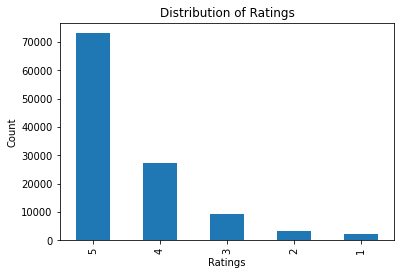

In [14]:
# Rating Distribution
kindle_df.rating.value_counts().plot(kind='bar')
plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.show()

### Label Assignment

In [15]:
# Creating a backup file
kindle_df1 = kindle_df.copy()

### Preparing Dataset for Binary Classification

- Excluding records with a neutral review rating of 3 for this binary classification sentiment analysis project
- Grouping the records with positive review ratings of 4 and 5 as the sentiment "1" (positive) and those with negative review ratings of 1 and 2 as the sentiment "0" (negative)

In [16]:
# Excluding the records with review rating 3 from the dataset
kindle_df1 = kindle_df1[kindle_df1['rating'] != 3]

In [17]:
# Creating 1 and 0 sentiment labels for the records
kindle_df1['sentiment'] = kindle_df1['rating'].apply(lambda x: 1 if x>3 else 0)

### Analyzing the distribution of both the sentiments

In [18]:
# The final raw dataset for further analysis
kindle_df2 = kindle_df1[['review','sentiment']]
kindle_df2.head(5)

,review,sentiment
0,I enjoyed this one tho I'm not sure why it's c...,1
1,I thought it would be instructive to compare t...,1
2,I live in a town adjacent a 'medium' sized cit...,1
3,A manual on desert island survival in its own ...,1
4,The author had a great story line. Brought eac...,1


In [19]:
kindle_df2.sentiment.value_counts()

1    100379
0      5347
Name: sentiment, dtype: int64

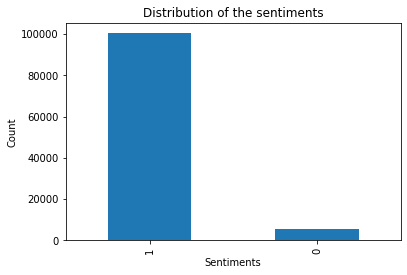

In [20]:
# Bar plot for analyzing the distribution of the two sentiments
kindle_df2.sentiment.value_counts().plot(kind='bar')
plt.title("Distribution of the sentiments")
plt.xlabel("Sentiments")
plt.ylabel("Count")
plt.show()

## Data Pre-processing

### Defining functions for data pre-processing

In [21]:
# Default stopwords list from package
stop_words = set(stopwords.words('english'))
stop_words_custom = list(stop_words)

# Removing punctuation from stopwords
temp = []
for i in stop_words_custom:
    temp.append(re.sub(r'[^a-z0-9\s]', '', i))

# Updating stopwords list to create a custome_stopwords list
to_add = ['im', 'its']
stops = ["not","doesnt","didnt","wouldnt","shouldnt","couldnt","very","too","really","so"]
custom_stopwords = list(set(temp) - set(stops) | set(to_add))

In [22]:
# A function for cleaning data

def clean(review_text):
    review_text = str(review_text).lower() # Converting to lowercase
    #review_text = re.sub('\[.*?\]', '', review_text)
    review_text = re.sub('https?://\S+|www\.\S+', '', review_text) # Removing URls
    review_text = re.sub('<.*?>+', '', review_text) # Removing special characters
    review_text = re.sub(r'[^a-z0-9\s]', '', review_text) # Removing punctuation
    review_text = re.sub('\n', '', review_text) # Removing '\n' character
    review_text = re.sub('\w*\d\w*', '', review_text)
    review_text = re.sub('\s+',' ', review_text) #Replaceing multiple spaces with asingle space
    return(review_text)

#### Cleaning Data

In [23]:
kindle_df3 = kindle_df2.copy()
kindle_df3['review'] = kindle_df3['review'].apply(clean)

#### Removing Stopwords

In [24]:
# Removing stopwords
kindle_df3['reviews_cleaned'] = kindle_df3['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (custom_stopwords)]))


In [25]:
kindle_df4 = kindle_df3[['reviews_cleaned','sentiment']]
kindle_df4.head(2)

,reviews_cleaned,sentiment
0,enjoyed one tho not sure called amy brewster m...,1
1,thought would instructive compare charles john...,1


### Train-test split (70:30 ratio)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(kindle_df4['reviews_cleaned'], 
                                                    kindle_df4['sentiment'], 
                                                    test_size=0.3, random_state=42, 
                                                    stratify=kindle_df4['sentiment'].values)

In [27]:
# Resetting index
train_df = pd.DataFrame(dict(review = X_train, sentiment = y_train)).reset_index(drop=True)
test_df = pd.DataFrame(dict(review = X_test, sentiment = y_test)).reset_index(drop=True)

In [28]:
train_df.shape

(74008, 2)

In [29]:
train_df.sentiment.value_counts()

1    70265
0     3743
Name: sentiment, dtype: int64

### Upsampling train dataset

In [30]:
review_pos =  train_df[(train_df['sentiment']== 1)]
review_neg = train_df[(train_df['sentiment']== 0)]

In [31]:
# Upsampling train dataset
review_neg_upsample = resample(review_neg, 
                                 replace=True,    # sample with replacement
                                 n_samples= 70265, # to match majority class
                                 random_state=42)  # reproducible results

In [32]:
# Upsampled train dataset
kindle_df_train = pd.concat([review_pos,review_neg_upsample])

In [33]:
kindle_df_train.shape

(140530, 2)

In [34]:
# 50:50 ratio of records for the two sentiments
kindle_df_train.sentiment.value_counts()

1    70265
0    70265
Name: sentiment, dtype: int64

## Baseline Models

In [35]:
# Upsampled train sets used to feed into the models
X_train_up = kindle_df_train['review']
y_train_up = kindle_df_train["sentiment"]

### Naive Bayes

In [40]:
# Creating a pipeline
model_nb = make_pipeline(TfidfVectorizer(ngram_range = (2,2)), 
                         MultinomialNB(alpha=1))

In [41]:
# Fitting the model with training set
model_nb.fit(X_train_up, y_train_up)

# Predicting the labels for the test set
labels_nb = model_nb.predict(X_test)

# Accuracy
print(f'Accuracy: {round(accuracy_score(y_test, labels_nb)*100,2)}%')

Accuracy: 95.03%


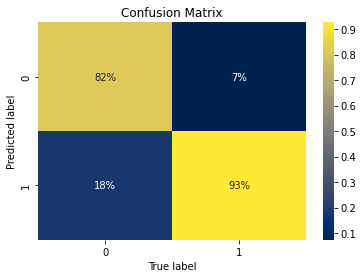

In [123]:
# Creating the confusion matrix
conf_mat = confusion_matrix(y_test, labels_nb, normalize="true")

# Plotting the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis")
plt.title('Confusion Matrix')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

### Logistic Regression

In [45]:
# Fitting the CountVectorizer to the training data
# Transforming the documents in the training data to a document-term matrix
vect = CountVectorizer(ngram_range= (2,2)).fit(X_train_up)
X_train_vectorized = vect.transform(X_train_up)

# Training the model
model_logit = LogisticRegression()

# Fitting the model
model_logit.fit(X_train_vectorized, y_train_up)

# Predicting the transformed test documents
predictions = model_logit.predict(vect.transform(X_test))

# Accuracy
print(f'ROC AUC Score: {round(roc_auc_score(y_test, predictions)*100,2)}%')
print(f'Accuracy: {round(accuracy_score(y_test, predictions)*100,2)}%')

# Getting the feature names as numpy array
feature_names = np.array(vect.get_feature_names())

# Sorting the coefficients from the model
sorted_coef_index = model_logit.coef_[0].argsort()

# Finding the 10 smallest and 10 largest coefficients
# The 10 largest coefficients are being indexed using [:-11:-1] so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

ROC AUC Score: 78.63%
Accuracy: 96.75%
Smallest Coefs:
['not worth' 'waste time' 'couldnt finish' 'couldnt get' 'poorly written'
 'not recommend' 'waste money' 'not well' 'two stars' 'glad free']

Largest Coefs: 
['not put' 'cant wait' 'loved book' 'must read' 'great read' 'great book'
 'highly recommend' 'look forward' 'highly recommended' 'good read']


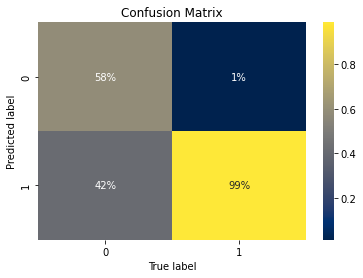

In [51]:
# Creating the confusion matrix
conf_mat = confusion_matrix(y_test, predictions, normalize="true")

# Plotting the confusion matrix
sns.heatmap(conf_mat.T, annot=True, fmt=".0%", cmap="cividis")
plt.title('Confusion Matrix')
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()

## Sequential Models

### Deep Learning Neural Networks

#### Word Embeddings

NOTE: The cleaned dataset without punctuations, removing stopwords and extra speces is: kindle_df4

In [52]:
# Tokenizing the documents
tokenizer_dl = Tokenizer(oov_token="UNKNOWN_TOKEN")
tokenizer_dl.fit_on_texts(kindle_df4['reviews_cleaned'])

In [53]:
# Calculating the size of vocabulary
vocab_size = int(len(tokenizer_dl.word_index) * 1.3)
print(f"Vocab size is {vocab_size} unique tokens.")

Vocab size is 210440 unique tokens.


#### Integer Encoding the Documents

In [54]:
# A function to integer encode the documents
def integer_encode_documents(docs, tokenizer):
    return tokenizer_dl.texts_to_sequences(docs)

In [55]:
# Integer encoding the documents
encoded_docs = integer_encode_documents(kindle_df4['reviews_cleaned'], tokenizer_dl)

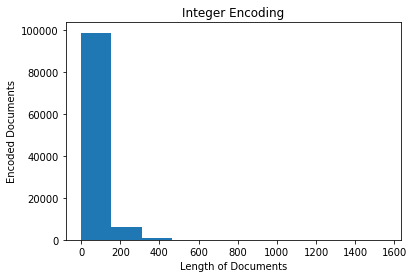

In [56]:
# A histogram for integer encoded documents
plt.hist(list(map(lambda doc: len(doc), encoded_docs)))
plt.xlabel('Length of Documents')
plt.ylabel('Encoded Documents')
plt.title('Integer Encoding')
plt.show()

#### Maximum Token Length

In [58]:
# A function to get the maximum token per document
def get_max_token_length_per_doc(docs: List[str], tokenizer)-> int:
  return max(list(map(lambda doc: len(doc), tokenizer_dl.texts_to_sequences(docs))))

In [59]:
cleaned_reviews_ls = list(kindle_df4['reviews_cleaned'].values)

In [60]:
# Getting the maximum length in terms of token length
max_length = get_max_token_length_per_doc(cleaned_reviews_ls, tokenizer_dl)
max_length

1554

#### Padding the documents

In [61]:
# Padding the documents
padded_docs = pad_sequences(encoded_docs, maxlen = max_length, padding='post')

#### Embedding Size

NOTE: For deciding embedding size - A good rule of thumb is atleast 4th root of vocabulary length. 

Using this as basis, we decided to use an embedding size of 50, to improve the learning.

In [62]:
# Fourth root of vocabulary size(length)
print(int(161877**(1/4)))

20


In [64]:
labels_dl = np.array(kindle_df4['sentiment'])

In [86]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs,
                                                    labels_dl, 
                                                    test_size=0.3,
                                                    stratify=labels_dl)

In [87]:
# Defining hyperparameters
embedding_size = 50

# Defining the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
model.add(Flatten())

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid')) 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# Summarizing the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1554, 50)          10522000  
                                                                 
 flatten_6 (Flatten)         (None, 77700)             0         
                                                                 
 dense_13 (Dense)            (None, 50)                3885050   
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 14,407,101
Trainable params: 14,407,101
Non-trainable params: 0
_________________________________________________________________


In [88]:
# Fitting the model
model.fit(X_train, y_train, epochs=2)

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
2313/2313 [==============================] - 355s 153ms/step - loss: 0.1182 - acc: 0.9600
Epoch 2/2
992/992 [==============================] - 12s 12ms/step - loss: 0.0923 - acc: 0.9678
Accuracy: 96.784163


Evaluating the model

In [89]:
# Predicting on test data
y_pred = np.where(model.predict(X_test)[:]>=0.5,1,0)
# Evaluate the model
score = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score,2)*100}%')

Accuracy: 97.0%


Predicting on test data

In [102]:
import spacy
nlp = spacy.load("en_core_web_sm", disable = ['ner', 'tagger', 'parser'])


test_docs = ["I'd never read any of the Amy Brewster mysteries until this one..  So I am really hooked on them now.",
 'The arabian fantasy, slavegirl trained to seduce and submit herself. Not to my taste, too much sex and not very erotic. Kind of mechanical.........',
 "Admittedly, I only read the first few stories.  They seemed disjointed, didn't flow, or seem to have a point.  It was written as if it were &#34;I tripped as I walked down the street.  The bus went downtown.  The end&#34;  Perhaps they just didn't translate well, or maybe they put the worst stories in the beginning.",
 'I should have know by the cover it was a bit out of my taste for books.  It started out good, but i got bored before i finished.mary',
 '2 star, quality of writing okay, story okay, female character, if you can call it a character, is horrid.  2/3 through book and I know she has freckles, brown hair, has the same ugly brown dress on, and is angry.  Who cares what happens to her?  Not me.  The male character is a better character.',
 "This was a fairly interesting read.  It had old- style terminology.I was glad to get  to read a story that doesn't have coarse, crasslanguage.  I read for fun and relaxation......I like the free ebooksbecause I can check out a writer and decide if they are intriguing,innovative, and have enough of the command of Englishthat they can convey the story without crude language.",
 'This one promises to be another good book. I have been reading through the series and have not gotten this far yet.',
 "I think I have this one in both book and audio. It is a good story either way. good ol' Maul.",
 "Maris' story is 2 1/2 stars for me, the bump to a half star owing to the gathering of the family at the end. The story, unfortunately, suffers from telling and not showing plot details. The chemistry between Maris and Alex suffers from this as well. The reader is thrown into the present without adequate descriptions of past meetings and attraction between the couple. (The suspenseful aspect to the novel also suffers from this.) Flashback scenes would have helped tremendously. Those familiar with the Mackenzie Family books expect instant attraction between the hero and heroine, but it's just not developed in this one.",
 'I really enjoyed the book. Had the normal back against the wall moments. It even had laugh out loud moments.',
 'Nothing against the author or the story. From the beginning I thought it was going to be an awesome story.I just cant do the historical fiction....I cant get passed all those Thee and Thou...spoils a good story for me....',
 'A beautiful in-depth character description makes it like a fast pacing movie. It is a pity Mr Merwin did not write 30 instead only 3 of the Amy Brewster mysteries.',
 'If you like period pieces - clothing, lingo, you will enjoy this mystery.  Author had me guessing at least 2/3 of the way through.',
 "I have not received one of my fourteen free copy of the NYT so please end my non subscription at this time, meaning I'm not agreeable to any charges being placed against my account for NYT.  Thank you.  Douglas",
 "I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.",
 ]

test_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), test_docs))

encoded_test_sample = integer_encode_documents(test_docs, tokenizer_dl)

padded_test_docs = pad_sequences(encoded_test_sample, maxlen=max_length, padding='post')

In [103]:
model.predict(padded_test_docs)

array([[0.94792056],
       [0.3995532 ],
       [0.82268393],
       [0.4607838 ],
       [0.01785573],
       [0.9926038 ],
       [0.9487511 ],
       [0.46120083],
       [0.98131347],
       [0.9979147 ],
       [0.8825573 ],
       [0.5605101 ],
       [0.8417435 ],
       [0.93510824],
       [0.9987896 ]], dtype=float32)

### One-Dimensional Convolution Neural Network

In [81]:
# Defining the model
model_cnn = Sequential()
model_cnn.add(Embedding(vocab_size, 32, input_length=max_length))

model_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_cnn.add(MaxPooling1D(pool_size=2, strides=1))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model_cnn.add(Flatten())

# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dropout(0.2))

# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dropout(0.5))

# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(1, activation='sigmoid'))

In [82]:
# Compiling the model
model_cnn.compile(optimizer='adam', loss="binary_crossentropy", metrics=['acc'])

# Summarizing the model
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1554, 32)          6734080   
                                                                 
 conv1d_3 (Conv1D)           (None, 1552, 32)          3104      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1551, 32)         0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 49632)             0         
                                                                 
 dense_12 (Dense)            (None, 1)                 49633     
                                                                 
Total params: 6,786,817
Trainable params: 6,786,817
Non-trainable params: 0
____________________________________________

In [83]:
# Fitting the model
model_cnn.fit(X_train, y_train, epochs=2)
# Evaluating the model
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))

Epoch 1/2
2313/2313 [==============================] - 315s 136ms/step - loss: 0.1125 - acc: 0.9626
Epoch 2/2
992/992 [==============================] - 16s 16ms/step - loss: 0.0880 - acc: 0.9727
Train accuracy: 97.272843


In [ ]:
# Predicting on test data
y_pred = np.where(model_cnn.predict(X_test)[:]>=0.5,1,0)
# Evaluate the model
score_cnn = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score_cnn,2)*100}%')

### RNN and LSTM

#### Encoding labels

In [111]:
encoder = LabelEncoder()
labels_rnn = to_categorical(encoder.fit_transform(labels_dl))

In [112]:
labels_rnn

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

#### Train Test Split

In [113]:
X_train, X_test, y_train, y_test = train_test_split(padded_docs,
                                                    labels_rnn, 
                                                    test_size=0.3,
                                                    stratify=labels_rnn)

#### Defining a function for RNN Model

In [114]:
# Defining RNN model
def rnn_classification_model(plot = False):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
  model.add(Masking(mask_value = 0.0))
  model.add(SimpleRNN(units = 64, input_shape = (1, max_length)))
  model.add(Dense(16))
  model.add(Dense(2, activation = 'softmax'))

  # Compiling the model
  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  # Summarizing the model
  model.summary()

  if plot:
    plot_model(model, to_file='model.png', show_shapes = True)
  return model

#### Defining a function for LSTM Model

In [115]:
# Defining LSTM model
def lstm_classification_model(plot = False):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_size, input_length=max_length))
  #model.add(Masking(mask_value = 0.0))
  model.add(LSTM(units = 32
                 , input_shape = (1, max_length)
                 , dropout=0.2))
  model.add(Flatten())
  model.add(Dense(20, activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(2, activation = 'softmax'))
  
  # Compiling the model
  model.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  # Summarizing the model
  model.summary()

  if plot:
    plot_model(model, to_file='model.png', show_shapes = True)
  return model

#### Defining a function for Plotting Fit History

In [116]:
# A function for Fit History
def plot_fit_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


#### Compiling Models

In [117]:
model_lstm = lstm_classification_model()
print("***********************************************************")
model_rnn = rnn_classification_model()
print(model_lstm)
print(model_rnn)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1554, 50)          10522000  
                                                                 
 lstm_1 (LSTM)               (None, 32)                10624     
                                                                 
 flatten_8 (Flatten)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 20)                660       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_20 (Dense)            (None, 2)                 42        
                                                                 
Total params: 10,533,326
Trainable params: 10,533,326


#### Fitting Models - LSTM

In [150]:
#LSTM
history_lstm = model_lstm.fit(X_train, y_train, validation_split = 0.1, epochs=1, verbose=1)

2082/2082 [==============================] - 4300s 2s/step - loss: 0.2177 - accuracy: 0.9493 - val_loss: 0.2013 - val_accuracy: 0.9491


#### Evaluating Model - LSTM

In [152]:
y_test.mean()  # This is the baseline accuracy

0.5

In [153]:
# Evaluating the model
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))

992/992 [==============================] - 207s 208ms/step - loss: 0.2002 - accuracy: 0.9494
Accuracy: 94.942933


In [ ]:
# Predicting on test data
y_pred = np.where(model_lstm.predict(X_test)[:]>=0.5,1,0)
# Evaluate the model
score_lstm = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score_lstm,2)*100}%')

#### Fitting Model - RNN

In [118]:
# Fitting the model
history_rnn = model_rnn.fit(X_train, y_train,validation_split = 0.1, epochs=2, verbose=1)

Epoch 1/2
2082/2082 [==============================] - 1749s 840ms/step - loss: 0.2023 - accuracy: 0.9492 - val_loss: 0.2073 - val_accuracy: 0.9473
Epoch 2/2
2082/2082 [==============================] - 1750s 841ms/step - loss: 0.2007 - accuracy: 0.9497 - val_loss: 0.2073 - val_accuracy: 0.9473


#### Evaluating Model - RNN

In [119]:
# Evaluating the model
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print('Accuracy: %f' % (accuracy*100))

992/992 [==============================] - 124s 125ms/step - loss: 0.2015 - accuracy: 0.9494
Accuracy: 94.942933


In [120]:
# Predicting on test data
y_pred = np.where(model_lstm.predict(X_test)[:]>=0.5,1,0)
# Evaluate the model
score_rnn = accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score_rnn,2)*100}%')

Accuracy: 95.0%


# Appendix

In [ ]:
# kindle_df[kindle_df['rating'] == 3].review

In [ ]:
# x = kindle_df.iloc[[114981]]['review']
# x.iloc[0]

In [ ]:
## Test code - move to appendix
ls_max = []
ls_min = []

for i in range(len(encoded_docs)):
    if len(encoded_docs[i]) > 0:
      ls_max.append(max(encoded_docs[i]))
      ls_min.append(min(encoded_docs[i]))

In [ ]:
max(ls_max)

In [93]:
import spacy
nlp = spacy.load("en_core_web_sm", disable = ['ner', 'tagger', 'parser'])


test_docs = ["I'd never read any of the Amy Brewster mysteries until this one..  So I am really hooked on them now.",
 "Never heard of Amy Brewster. But I don't need to like Amy Brewster to like this book. Actually, Amy Brewster is a side kick in this story, who added mystery to the story not the one resolved it. The story brings back the old times, simple life, simple people and straight relationships.",
 'The arabian fantasy, slavegirl trained to seduce and submit herself. Not to my taste, too much sex and not very erotic. Kind of mechanical.........',
 "Admittedly, I only read the first few stories.  They seemed disjointed, didn't flow, or seem to have a point.  It was written as if it were &#34;I tripped as I walked down the street.  The bus went downtown.  The end&#34;  Perhaps they just didn't translate well, or maybe they put the worst stories in the beginning.",
 "I just couldn't get into this one very much. The protagonist was too far out. Wondering what she would have done if she'd had to get into a fist fight....but of course, guns were always the answer.",
 'I should have know by the cover it was a bit out of my taste for books.  It started out good, but i got bored before i finished.mary',
 '2 star, quality of writing okay, story okay, female character, if you can call it a character, is horrid.  2/3 through book and I know she has freckles, brown hair, has the same ugly brown dress on, and is angry.  Who cares what happens to her?  Not me.  The male character is a better character.',
 "This was a fairly interesting read.  It had old- style terminology.I was glad to get  to read a story that doesn't have coarse, crasslanguage.  I read for fun and relaxation......I like the free ebooksbecause I can check out a writer and decide if they are intriguing,innovative, and have enough of the command of Englishthat they can convey the story without crude language.",
 'This one promises to be another good book. I have been reading through the series and have not gotten this far yet.',
 "I think I have this one in both book and audio. It is a good story either way. good ol' Maul.",
 "Maris' story is 2 1/2 stars for me, the bump to a half star owing to the gathering of the family at the end. The story, unfortunately, suffers from telling and not showing plot details. The chemistry between Maris and Alex suffers from this as well. The reader is thrown into the present without adequate descriptions of past meetings and attraction between the couple. (The suspenseful aspect to the novel also suffers from this.) Flashback scenes would have helped tremendously. Those familiar with the Mackenzie Family books expect instant attraction between the hero and heroine, but it's just not developed in this one.",
 'I really enjoyed the book. Had the normal back against the wall moments. It even had laugh out loud moments.',
 'Nothing against the author or the story. From the beginning I thought it was going to be an awesome story.I just cant do the historical fiction....I cant get passed all those Thee and Thou...spoils a good story for me....',
 'A beautiful in-depth character description makes it like a fast pacing movie. It is a pity Mr Merwin did not write 30 instead only 3 of the Amy Brewster mysteries.',
 'If you like period pieces - clothing, lingo, you will enjoy this mystery.  Author had me guessing at least 2/3 of the way through.',
 "I have not received one of my fourteen free copy of the NYT so please end my non subscription at this time, meaning I'm not agreeable to any charges being placed against my account for NYT.  Thank you.  Douglas",
 "This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.",
 "I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.",
 "just not my thing.  it quickly degenerated into today's slide into slime.  It is a pity, he used to tell a good tale"]

test_docs = list(
    map(lambda doc: " ".join([token.text for token in nlp(doc) if not token.is_stop]), test_docs))

encoded_test_sample = integer_encode_documents(test_docs, tokenizer_dl)

padded_test_docs = pad_sequences(encoded_test_sample, maxlen=max_length, padding='post')

In [94]:
model.predict(padded_test_docs)

array([[0.94792056],
       [0.99773777],
       [0.3995532 ],
       [0.82268393],
       [0.92739546],
       [0.4607838 ],
       [0.01785573],
       [0.9926038 ],
       [0.9487511 ],
       [0.46120083],
       [0.98131347],
       [0.9979147 ],
       [0.8825573 ],
       [0.5605101 ],
       [0.84174347],
       [0.93510824],
       [0.9960748 ],
       [0.9987896 ],
       [0.77602005]], dtype=float32)